# GPT2 + Similarity

- fairy-tales 데이터 추가 전처리 (split 덜되어있는 부분 추가 split)
- generation과 similarity 혼합 구조 연구

## Flowchart

- generation flowchart

![generation flowchart drawio](https://user-images.githubusercontent.com/55081331/144010258-b2e98790-d7b9-4e9d-8053-b9f234fddfbd.png)

- generate + similarity flowchart

![generate+similarity drawio](https://user-images.githubusercontent.com/55081331/144010335-a9109f98-775d-42e2-bb05-a5403464ca0b.png)




## Install Packages

In [1]:
# !pip install transformers
# !pip install sentence-transformers
# !pip install git+https://github.com/ssut/py-hanspell.git

## Load Model & 후처리

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import nltk
from nltk.tokenize import sent_tokenize
import requests
from hanspell import spell_checker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "/content/drive/MyDrive/DOTORY/gpt2/"
checkpoint = torch.load(path + 'gpt2_1104.tar')

tokenizer = GPT2Tokenizer.from_pretrained(path)

model = GPT2LMHeadModel(GPT2Config.from_json_file(path + 'config.json'))
model.load_state_dict(checkpoint['model'])
model.to(device)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# kakao (crawling)
def translate_kakao(text, source, target):
    url = "https://translate.kakao.com/translator/translate.json"

    headers = {
        "Referer": "https://translate.kakao.com/",
        "User-Agent": "Mozilla/5.0"
    }

    data = {
        "queryLanguage": source,
        "resultLanguage": target,
        "q": text
    }

    resp = requests.post(url, headers=headers, data=data)
    data = resp.json()
    output = data['result']['output'][0][0] # 첫번째 문장만 return
    return output

In [ ]:
f = open("/content/drive/MyDrive/DOTORY/gpt2/filtering.txt", 'r')
filtering = f.read().split('\n')
f.close()

## EDA

In [ ]:
# f = open("/content/drive/MyDrive/DOTORY/merged_clean.txt", 'r')
# origin = f.read().split('\n\n\n')
# origin = list(filter(None, origin))
# f.close()
# len(origin)  # fairy tales 동화 개수 (전처리하고 더 줄어들거라 예상)

1884

(0, 407)

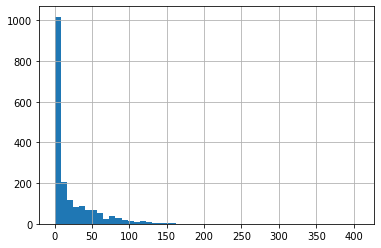

In [ ]:
# import pandas as pd
# import numpy as np

# f = open("/content/drive/MyDrive/DOTORY/merged_clean.txt", 'r')
# original = f.read().split('\n\n\n')
# original = list(filter(None, original))
# story_length = []
# for text in original:
#     stories = text.lstrip('\n').split('\n\n')[1:]
#     if len(stories):story_length.append(len(stories))
# f.close()
# pd.Series(story_length).hist(bins=50)  # story당 문장 개수 (더 많을 수 있음)
# min(story_length), max(story_length)

(1, 20182)

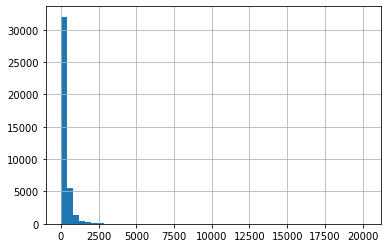

In [ ]:
# sentence_length = []
# for text in original:
#     story = text.lstrip('\n').split('\n\n')[1:]
#     for s in story:sentence_length.append(len(s))

# pd.Series(sentence_length).hist(bins=50)  # 문장 길이 분포 (유사도 기반으로 문장 뽑을거면 얘가 더 중요하긴 함, 더 split 필요)
# min(sentence_length), max(sentence_length)

In [2]:
# df = []
# for text in original:
#     stories = text.lstrip('\n').split('\n\n')[1:]
#     df.extend(stories)

# df[np.array(sentence_length).argmax()]  # split 덜되어있는 가장 긴 문장

In [ ]:
# len(sentence_db)  # split 전 전체 문장 개수 (아직 split 되지 않은 문장들이 많아서 기대보다 작은 size)

40000

In [ ]:
# with open('/content/drive/MyDrive/DOTORY/sentence_db.txt', 'w') as f:
#     for sentence in origin:
#         f.write(sentence + '\n')
# f.close()

In [ ]:
# f = open("/content/drive/MyDrive/DOTORY/sentence_db.txt", 'r')
# sentence_db = f.read().split('\n')
# f.close()

In [ ]:
import pandas as pd
import re

f = open("/content/drive/MyDrive/DOTORY/merged_clean.txt", 'r')
origin = f.read().split('\n\n\n')  # 동화 단위로 split
origin = list(filter(None, origin))
sentence_db = pd.DataFrame([], columns=['sentence', 'story_idx'])
for i in range(len(origin)):
    origin[i] = origin[i].lstrip('\n').split('\n\n')[1:]  # title 제거
    if origin[i]:
        for sentence in origin[i][1:len(origin[i])-2]:  # 1~n-2 (first, last 제외)
            sentence = sentence.replace('\n', ' ')
            if len(sentence) > 200:  # split
                a = re.split("([.?!’”]) ", sentence)
                sentences = [a[i-1] + a[i] for i in range(1, len(a), 2)] + [a[-1]]
                sentences = list(filter(None, sentences))
                for s in sentences:sentence_db = sentence_db.append({'sentence':s, 'story_idx':i}, ignore_index=True)
            else:
                sentence_db = sentence_db.append({'sentence':sentence, 'story_idx':i}, ignore_index=True)
f.close()
sentence_db

,sentence,story_idx
0,"'No, no!' said the king; 'you must not be in s...",0
1,"The prince was much disappointed, but he never...",0
2,"It was no use staying at home, so one day he w...",0
3,"'Good evening, mother. I see you have lived lo...",0
4,"'Yes, indeed, I've lived long and been much ab...",0
...,...,...
78696,Tom would not bring the flail into the palace.,1882
78697,You may be sure no other body went near it; an...,1882
78698,"But a messenger came in at noon, and said that...",1882
78699,"Well, I suppose, before they were married, Tom...",1882


In [ ]:
sentence_db.to_csv('/content/drive/MyDrive/DOTORY/sentence_db.csv', index=False)

In [ ]:
# first_db, last_db
import pandas as pd

f = open("/content/drive/MyDrive/DOTORY/merged_clean.txt", 'r')
total_db = f.read().split('\n\n\n')
total_db = list(filter(None, total_db))
first_db = []
last_db = []
for i in range(len(total_db)):
    total_db[i] = total_db[i].lstrip('\n').split('\n\n')[1:]
    if total_db[i]:
        first_db.append(total_db[i][0])
        last_db.append(total_db[i][-2:])
f.close()

first_db = pd.Series(first_db, name='first')
last_db = pd.DataFrame(last_db, columns=['last-1', 'last'])

first_db.to_csv('/content/drive/MyDrive/DOTORY/first_db.csv', index=False)
last_db.to_csv('/content/drive/MyDrive/DOTORY/last_db.csv', index=False)

## Generate

Only Generate

In [ ]:
import random

f = open("/content/drive/MyDrive/DOTORY/first_sentence.txt", 'r')
first_db = f.read().split('\n')
f.close()
first_db.remove('')

result = []

first_sentence = random.choice(first_db)
print('First sentence : ', first_sentence)
result.append(first_sentence)
input_sentence = translate_kakao(first_sentence, 'kr', 'en')  # papago : ko, kakao : kr
encoded = torch.LongTensor().to(device)

for i in range(20):
    encoded = torch.cat([encoded, torch.tensor(tokenizer.encode(input_sentence)).to(device)])
    print('Length of encoded:', len(encoded))
    generated = model.generate(encoded.unsqueeze(0), do_sample=True, use_cache=True, top_p=0.9, num_return_sequences=3, max_length=len(encoded)+100, min_length=len(encoded), temperature=0.6, pad_token_id=tokenizer.eos_token_id).to(device)  # length_penalty=10,
    generated = [generated[i][len(encoded):] for i in range(3)]  # input 중복 제거
    decoded = [tokenizer.decode(generated[i]) for i in range(3)]  # decode
    output_eng = [sent_tokenize(decoded[i])[0] if decoded[i] else decoded[i] for i in range(3)]  # 첫 번째 문장 분리, kakao 번역이 문장 단위로 잘라주기 때문에 translate_kakao에 decodede 그대로 들어감. 얘는 그저 output_eng를 위함
    output_kor = [translate_kakao(decoded[i], 'en', 'ku') for i in range(3)] # papgo : ko, kakao : ku (ku : 높임말 문체 in kakao)
    output_kor = [spell_checker.check(output_kor[i]).checked for i in range(3)]  # 맞춤법 검사
    for i in range(3):
        if sum([f in output_kor[i] for f in filtering]):  # filter it and new generate
            generated = model.generate(encoded.unsqueeze(0), do_sample=True, use_cache=True, top_p=0.9, num_return_sequences=1, max_length=len(encoded)+100, min_length=len(encoded), temperature=0.6, pad_token_id=tokenizer.eos_token_id).to(device)
            generated = generated[0][len(encoded):]
            decoded = tokenizer.decode(generated)
            try:output_eng[i] = sent_tokenize(decoded)[0]
            except:output_eng[i] = decoded
            output_kor[i] = translate_kakao(output_eng[i], 'en', 'ku')
            output_kor[i] = spell_checker.check(output_kor[i]).checked
        print('Generated ' + str(i+1) + ' : ', output_kor[i])
    next_idx = int(input('\nChoose the sentence number : ')) - 1
    print('Selected sentence : ', output_kor[next_idx])
    result.append(output_kor[next_idx])
    input_sentence = output_eng[next_idx]


First sentence :  잠자는 숲속의 공주가 있었어요.
Length of encoded: 9
Generated 1 :  그녀는 부드럽고 사랑스럽고 길고 흐르는 가운의 털 사이로 황금 실을 반짝였습니다.
Generated 2 :  그녀는 잤고, 3일째 아침까지 깨어났습니다.
Generated 3 :  그녀는 누구에게도 약속되지 않았기 때문에 진정한 공주가 아니었지만, 그녀가 원한다면 살 수 있었을 것입니다.

Choose the sentence number : 1
Selected sentence :  그녀는 부드럽고 사랑스럽고 길고 흐르는 가운의 털 사이로 황금 실을 반짝였습니다.
Length of encoded: 31
Generated 1 :  길고 흐르는 머리카락은 고양이의 머리카락이었고, 그녀의 눈은 너무 파란색이었고, 너무 맑아서 볼 수 있었습니다.
Generated 2 :  저녁의 빛에 이마에서 튀어나온 가시 두 개가 매달려 있었고, 그녀는 잠을 잤지만 왕자는 아직 침대에 누워 있지 않았습니다.
Generated 3 :  슬리퍼가 바닥을 따라 미끄러져 들어가자 젊은이는 몸을 숙여 공주의 야복을 움켜쥐고 무릎까지 끌어올렸습니다.

Choose the sentence number : 1
Selected sentence :  길고 흐르는 머리카락은 고양이의 머리카락이었고, 그녀의 눈은 너무 파란색이었고, 너무 맑아서 볼 수 있었습니다.
Length of encoded: 57
Generated 1 :  왕은 그녀를 보았고, 눈을 뗄 수 없었습니다.
Generated 2 :  왕자는 창백하고 떨렸지만 감히 소리 지르지 않았습니다.
Generated 3 :  공주는 눈물을 흘리며 왕자를 보며 기뻐하며 흔들었습니다.

Choose the sentence number : 3
Selected sentence :  공주는 눈물을 흘리며 왕자를 보며 기뻐하며 흔들었습니다.
Length of encoded: 72
Generated 1 :  그리고는 발치에 몸을 던지

KeyboardInterrupt: ignored

Generate + Similarity

In [ ]:
# load db files and embedding model

# import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
import pandas as pd

# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
# use = hub.load(module_url)
# def embed(input):
#   return use(input)
embed_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# first_db = pd.read_csv('/content/drive/MyDrive/DOTORY/first_db.csv')['first'].tolist()
f = open("/content/drive/MyDrive/DOTORY/first_sentence.txt", 'r')
first_db = f.read().split('\n')
f.close()
first_db.remove('')
last_db = pd.read_csv('/content/drive/MyDrive/DOTORY/last_db.csv')
sentence_db = pd.read_csv('/content/drive/MyDrive/DOTORY/sentence_db.csv')

last_embed = embed_model.encode(last_db['last-1'])
sentence_embed = embed_model.encode(sentence_db['sentence'])

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# select first & last from DB
# and mix retrieval and generate
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

result = []

# first_sentence = first_db.sample(1).values[0][0]
first_sentence = random.choice(first_db)
print('First sentence : ', first_sentence)
result.append(first_sentence)
input_sentence = translate_kakao(first_sentence, 'kr', 'en')  # papago : ko, kakao : kr
encoded = torch.LongTensor().to(device)
retrieval = True

for i in range(9):
    encoded = torch.cat([encoded, torch.tensor(tokenizer.encode(input_sentence)).to(device)])
    if retrieval:
        # retrieval 2 sentences
        input_embed = embed_model.encode(pd.Series(input_sentence))
        similarity = cosine_similarity(input_embed, sentence_embed)[0]
        done = 0
        sim_idx = 0
        output_eng = []
        while done < 2:
            if sentence_db['story_idx'][np.argmax(similarity) + sim_idx] == sentence_db['story_idx'][np.argmax(similarity) + sim_idx + 1]: # 다음 문장과 같은 동화일 경우
                output_eng.append(sentence_db['sentence'][np.argmax(similarity) + sim_idx + 1])
                done += 1
            sim_idx += 1
        output_kor = [translate_kakao(output_eng[i], 'en', 'ku') for i in range(2)]
        output_kor = [spell_checker.check(output_kor[i]).checked for i in range(2)]
        # generate 1 sentence
        generated = model.generate(encoded.unsqueeze(0), do_sample=True, use_cache=True, top_p=0.9, num_return_sequences=1, max_length=len(encoded)+100, min_length=len(encoded), temperature=0.6, pad_token_id=tokenizer.eos_token_id).to(device)  # length_penalty=10,
        generated = generated[0][len(encoded):]
        decoded = tokenizer.decode(generated)
        try:output_eng.append(sent_tokenize(decoded)[0])
        except:output_eng.append(decoded)
        output_kor.append(spell_checker.check(translate_kakao(decoded, 'en', 'ku')).checked)
        retrieval = False
    else:
        # generate 3 sentences
        generated = model.generate(encoded.unsqueeze(0), do_sample=True, use_cache=True, top_p=0.9, num_return_sequences=3, max_length=len(encoded)+100, min_length=len(encoded), temperature=0.6, pad_token_id=tokenizer.eos_token_id).to(device)  # length_penalty=10,
        generated = [generated[i][len(encoded):] for i in range(3)]  # input 중복 제거
        decoded = [tokenizer.decode(generated[i]) for i in range(3)]  # decode
        output_eng = [sent_tokenize(decoded[i])[0] if decoded[i] else decoded[i] for i in range(3)]  # 첫 번째 문장 분리, kakao 번역이 문장 단위로 잘라주기 때문에 translate_kakao에 decodede 그대로 들어감. 얘는 그저 output_eng를 위함
        output_kor = [translate_kakao(decoded[i], 'en', 'ku') for i in range(3)] # papgo : ko, kakao : ku (ku : 높임말 문체 in kakao)
        output_kor = [spell_checker.check(output_kor[i]).checked for i in range(3)]  # 맞춤법 검사
        retrieval = True

    for i in range(3):
        if sum([f in output_kor[i] for f in filtering]) or len(output_kor[i]) < 5:  # filter it and new generate
            generated = model.generate(encoded.unsqueeze(0), do_sample=True, use_cache=True, top_p=0.9, num_return_sequences=1, max_length=len(encoded)+100, min_length=len(encoded), temperature=0.6, pad_token_id=tokenizer.eos_token_id).to(device)
            generated = generated[0][len(encoded):]
            decoded = tokenizer.decode(generated)
            try:output_eng[i] = sent_tokenize(decoded)[0]
            except:output_eng[i] = decoded
            output_kor[i] = translate_kakao(output_eng[i], 'en', 'ku')
            output_kor[i] = spell_checker.check(output_kor[i]).checked
        print('Generated ' + str(i+1) + ' : ', output_kor[i])
    next_idx = int(input('\nChoose the sentence number : ')) - 1
    print('Selected sentence : ', output_kor[next_idx])
    result.append(output_kor[next_idx])
    input_sentence = output_eng[next_idx]

last_generated = embed_model.encode(pd.Series(input_sentence))
similarity = cosine_similarity(last_generated, last_embed)[0]
last_sentence = last_db['last'][np.argmax(similarity)]
last_sentence_kor = translate_kakao(last_sentence, 'en', 'ku')
print('Selected last sentence : ', last_sentence_kor)

First sentence :  옛날에 노래하기를 좋아하는 소녀가 살고 있었어요.
Generated 1 :  “말 안 할 거예요.” 가터가 말했다.
Generated 2 :  “거처는 어디 있습니까?” 셔츠 칼라가 물었다.
Generated 3 :  그녀는 지구의 탄생, 예술과 과학, 인류의 탄생, 인류의 행복을 노래했습니다.

Choose the sentence number : 3
Selected sentence :  그녀는 지구의 탄생, 예술과 과학, 인류의 탄생, 인류의 행복을 노래했습니다.
Generated 1 :  그녀는 마법사 마법사에 대한 인류의 승리와 신들의 몰락을 노래했습니다.
Generated 2 :  그녀는 자연의 노래와 인간의 영혼의 노래를 이해했기 때문에 인류의 슬픔과 미래의 기쁨을 노래했습니다.
Generated 3 :  그녀는 희망과 불멸을 노래하고, 세계의 사악함, 인간의 몰락, 요정 공주의 승리에 대해 노래했습니다.

Choose the sentence number : 2
Selected sentence :  그녀는 자연의 노래와 인간의 영혼의 노래를 이해했기 때문에 인류의 슬픔과 미래의 기쁨을 노래했습니다.
Generated 1 :  그리고 장미는 동쪽 하늘의 장미처럼 진홍색으로 변했습니다.
Generated 2 :  그러나 나이팅게일의 목소리는 점점 희미 해졌고, 그녀의 작은 날개가 달리기 시작했고, 그녀의 눈 위로 영화가 쾅쾅 거리고 있었습니다.
Generated 3 :  젊은 학생은 노인의 방에 앉아 그의 말도 안 되는 소리를 듣고 달, 태양계 및 세상에 나오는 남자에 대해 이야기했습니다.

Choose the sentence number : 1
Selected sentence :  그리고 장미는 동쪽 하늘의 장미처럼 진홍색으로 변했습니다.
Generated 1 :  하지만 그중에서도 가장 멋진 것은 장미 그 자체였습니다.
Generated 2 :  하지만 황금 자물쇠의 공주는 이 장미를 본 적이 없습니다.
Generate

KeyboardInterrupt: ignored